In [1]:
import glob
import random

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from icecream import ic
from mpl_toolkits.axes_grid1 import ImageGrid

import label_mapping
from ext.mindboggle.labels import extract_numbers_names_colors

In [2]:
KWYK_DATA = "/nese/mit/group/sig/data/kwyk/rawdata"
asegs = glob.glob(KWYK_DATA + "/*aseg*")

aseg_file = random.choice(asegs)
ic(aseg_file)
aseg = nib.load(aseg_file).get_fdata().astype(np.uint)
ic(aseg.shape)

ic| aseg_file: '/nese/mit/group/sig/data/kwyk/rawdata/pac_7923_aseg.nii.gz'
ic| aseg.shape: (256, 256, 256)


(256, 256, 256)

In [3]:
n_classes = 50  # 6 or 50 or 115
label_map = label_mapping.get_label_mapping(n_classes)

Using label mapping file: /om2/user/hgazula/nobrainer_training_scripts/csv-files/50-class-mapping.csv
Conversion into 50 segmentation classes from freesurfer labels


In [4]:
u, inv = np.unique(aseg, return_inverse=True)
aseg_new = np.array([label_map.get(x, 0) for x in u])[inv].reshape(aseg.shape)

ic(len(np.unique(aseg_new)))
print()

ic| len(np.unique(aseg_new)): 50


In [5]:
fs_number, fs_names, fs_colors = extract_numbers_names_colors(
    "/om2/user/hgazula/freesurfer/FreeSurferColorLUT.txt"
)

if n_classes == 115:
    df = pd.read_csv(
        "/om2/user/hgazula/nobrainer_training_scripts/csv-files/115-class-mapping.csv",
        header="infer",
    )
else:
    df = pd.read_csv(
        "/om2/user/hgazula/nobrainer_training_scripts/csv-files/50-class-mapping.csv",
        header="infer",
        index_col=0,
    )

df["colors"] = df["original"].apply(lambda x: fs_colors[fs_number.index(x)])
df = df.drop_duplicates(subset="new")

my_colors = df.colors.tolist()
my_colors[0] = [255, 255, 255]  # replacing background with white color
cmap = mcolors.ListedColormap(np.array(my_colors) / 255)

# assert len(np.unique(aseg_new)) == len(my_colors), "invalid number of classes"

Code from Sergey

In [6]:
def crop_tensor(tensor, percentile=10):
    # Create a copy of the tensor to avoid modifying the original
    data_for_processing = tensor.copy()

    # Thresholding (assuming background has very low values compared to the head)
    threshold = np.percentile(data_for_processing, percentile)
    data_for_processing[data_for_processing < threshold] = 0

    # Find the bounding box around the head (non-zero region) in the filtered data
    indices = np.nonzero(data_for_processing)
    min_z, max_z = np.min(indices[0]), np.max(indices[0])
    min_y, max_y = np.min(indices[1]), np.max(indices[1])
    min_x, max_x = np.min(indices[2]), np.max(indices[2])

    # Crop the original tensor using the bounding box from the filtered data
    cropped_tensor = tensor[min_z : max_z + 1, min_y : max_y + 1, min_x : max_x + 1]

    return cropped_tensor


def plot_tensor_slices(tensor, slice_dim=0, cmap="viridis", crop_percentile=10):
    # Crop the tensor
    cropped_tensor = crop_tensor(tensor, percentile=crop_percentile)

    # Determine the dimensions of the cropped tensor
    dim0, dim1, dim2 = cropped_tensor.shape

    # Determine the slicing dimensions based on the specified slice_dim
    if slice_dim == 0:
        num_slices = dim0
        slice_shape = (dim1, dim2)
    elif slice_dim == 1:
        num_slices = dim1
        slice_shape = (dim0, dim2)
    elif slice_dim == 2:
        num_slices = dim2
        slice_shape = (dim0, dim1)
    else:
        raise ValueError("Invalid slice_dim. Must be 0, 1, or 2.")

    # Calculate the grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_slices)))

    # Create a larger matrix to hold the slices
    R = np.zeros((grid_size * slice_shape[0], grid_size * slice_shape[1]))

    # Iterate over the slices and place them in the larger matrix
    for i in range(grid_size):
        for j in range(grid_size):
            slice_index = i * grid_size + j
            if slice_index < num_slices:
                if slice_dim == 0:
                    slice_data = cropped_tensor[slice_index, :, :]
                elif slice_dim == 1:
                    slice_data = cropped_tensor[:, slice_index, :]
                else:  # slice_dim == 2
                    slice_data = cropped_tensor[:, :, slice_index]
                R[
                    i * slice_shape[0] : (i + 1) * slice_shape[0],
                    j * slice_shape[1] : (j + 1) * slice_shape[1],
                ] = slice_data

    # Plot the larger matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(R, cmap=cmap, interpolation="nearest")
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig("sergey_plot.png", dpi=600)
    plt.show()

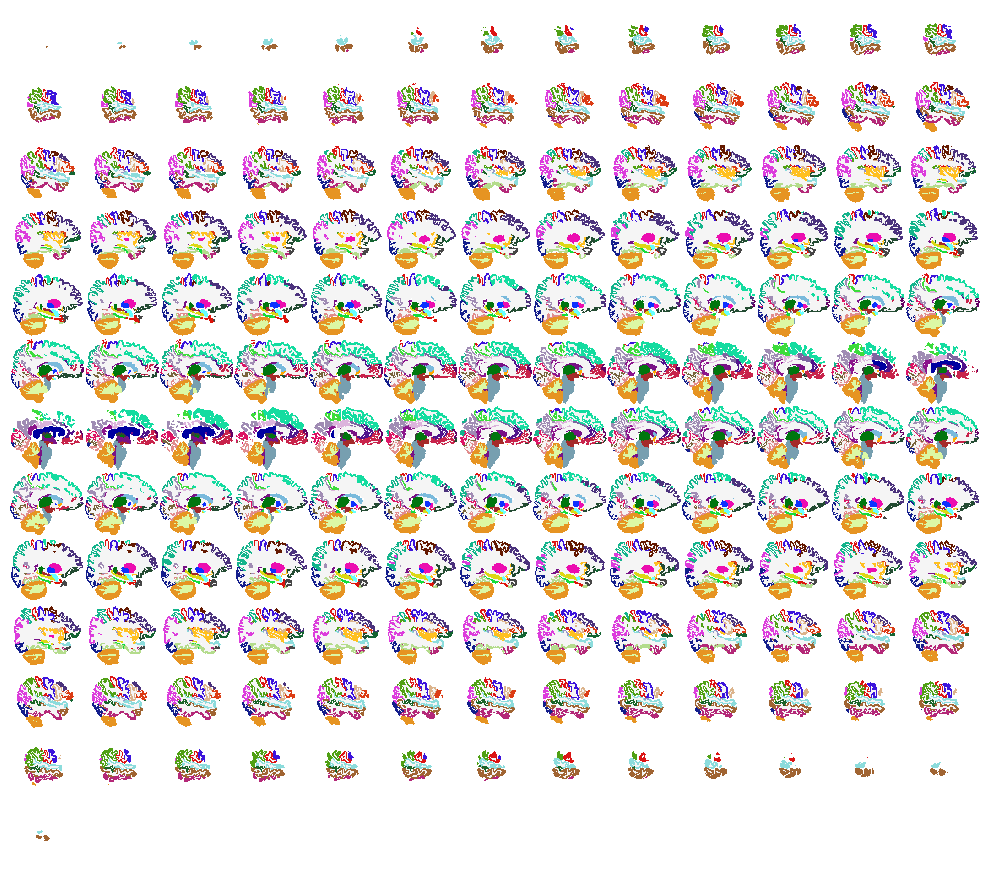

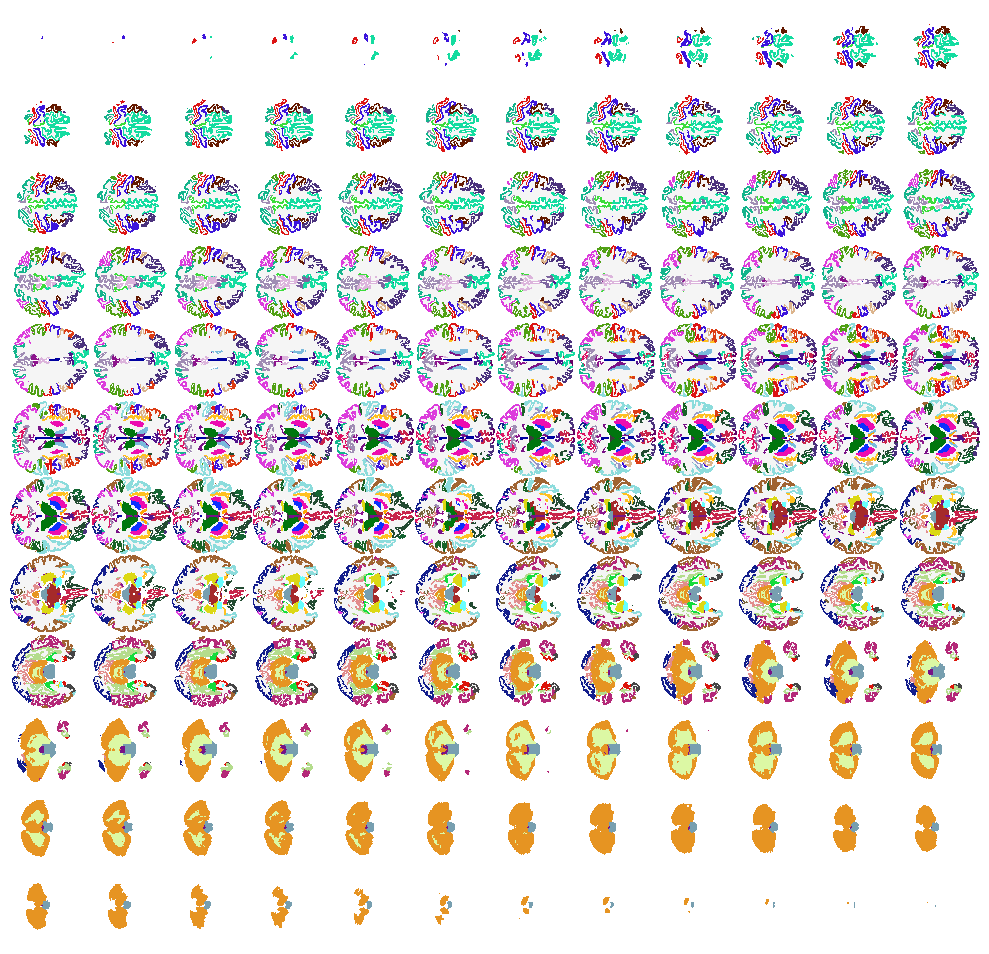

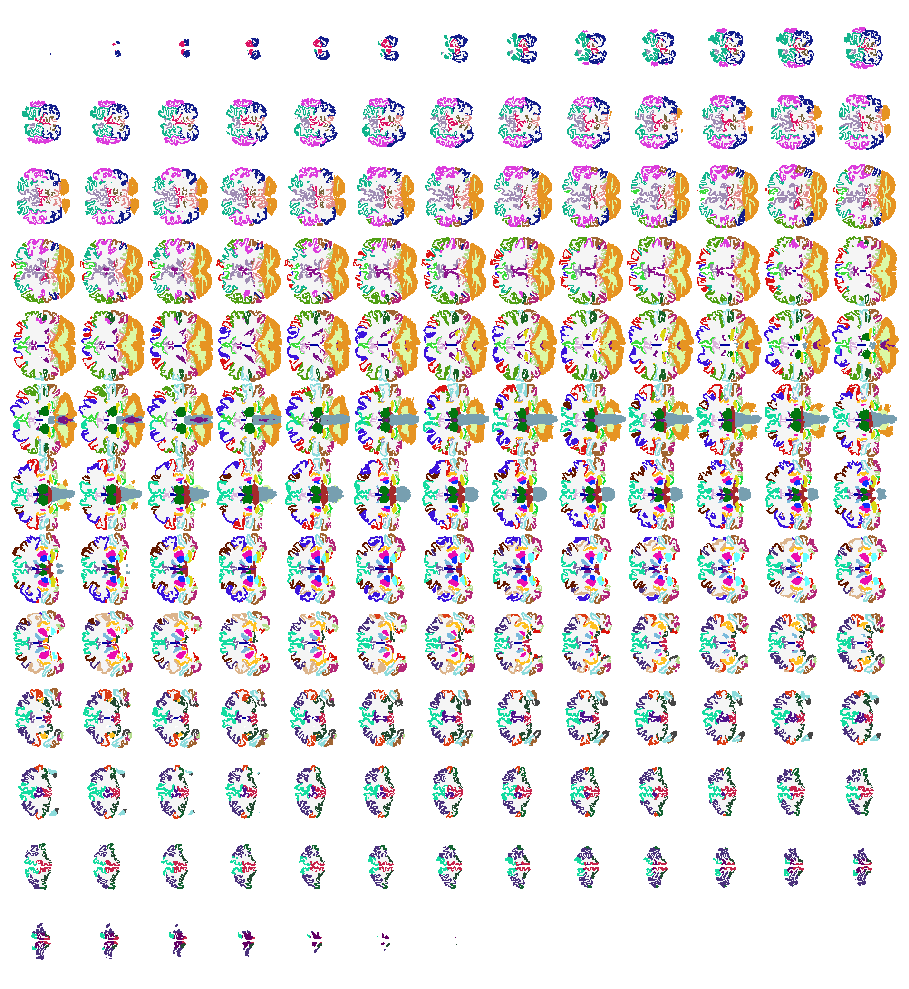

In [7]:
for slice_dim in range(3):
    plot_tensor_slices(aseg_new, slice_dim=slice_dim, cmap=cmap, crop_percentile=10)